In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.decomposition import LatentDirichletAllocation

from imblearn.over_sampling import SMOTE

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sns.set(style="whitegrid")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tomiwa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
df = pd.read_csv("/Users/tomiwa/Downloads/Cleaned_Reddit_Data.csv")
df['cleaned_text'] = df['cleaned_text'].astype(str)

if 'sentiment' not in df.columns:
    vader = SentimentIntensityAnalyzer()
    df['compound_score'] = df['cleaned_text'].apply(lambda text: vader.polarity_scores(text)['compound'])

    def classify_sentiment(score):
        if score >= 0.05:
            return 'Positive'
        elif score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df['sentiment'] = df['compound_score'].apply(classify_sentiment)

print(df['sentiment'].value_counts())


sentiment
Positive    119
Negative     68
Neutral      13
Name: count, dtype: int64


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment']
)


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_tfidf, y_train)

model = LogisticRegression(v
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced'  
)
model.fit(X_resampled, y_resampled)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')


📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.53      0.62      0.57        13
     Neutral       0.00      0.00      0.00         3
    Positive       0.68      0.71      0.69        24

    accuracy                           0.62        40
   macro avg       0.40      0.44      0.42        40
weighted avg       0.58      0.62      0.60        40


🌟 Macro F1-Score: 0.4218


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


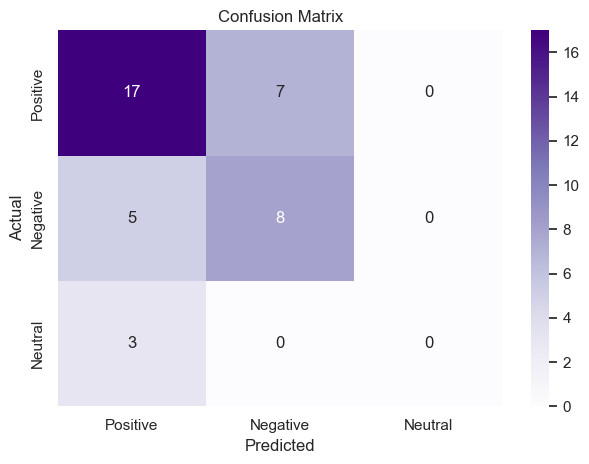

In [27]:
y_pred = model.predict(X_test_tfidf)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Custom F1 Evaluation
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\n🌟 Macro F1-Score: {macro_f1:.4f}")

# Confusion Matrix
labels = ["Positive", "Negative", "Neutral"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [19]:
feature_names = vectorizer.get_feature_names_out()

for i, class_label in enumerate(model.classes_):
    print(f"\n🔍 Top Predictive Words for '{class_label}':")
    class_coeffs = model.coef_[i]
    top_features = sorted(zip(class_coeffs, feature_names), reverse=True)[:10]
    for coef, feat in top_features:
        print(f"{feat}: {round(coef, 4)}")


🔍 Top Predictive Words for 'Negative':
crisis: 0.5827
investors: 0.5666
government: 0.5022
federal: 0.481
rental: 0.3904
believe: 0.3795
homes: 0.368
war: 0.3619
people: 0.3601
half: 0.354

🔍 Top Predictive Words for 'Neutral':
jump: 1.0708
hits: 1.0225
rents: 1.0046
driving: 0.8794
explodes: 0.8356
homelessness: 0.7355
situations: 0.7311
america: 0.7211
fewer: 0.685
aint: 0.6805

🔍 Top Predictive Words for 'Positive':
did: 0.4614
buy: 0.3791
just: 0.3406
cities: 0.3255
like: 0.3245
2024: 0.3163
need: 0.3158
want: 0.3097
im: 0.2883
car: 0.2881


In [20]:
def topic_modeling_by_sentiment(sentiment_label, n_topics=3, n_words=8):
    subset = df[df['sentiment'] == sentiment_label]
    tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = tfidf.fit_transform(subset['cleaned_text'])

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tfidf_matrix)

    print(f"\n🧩 Topics for {sentiment_label} Sentiment:")
    for idx, topic in enumerate(lda.components_):
        top_words = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-n_words:][::-1]]
        print(f"  - Topic {idx+1}: {' | '.join(top_words)}")

for sentiment in df['sentiment'].unique():
    topic_modeling_by_sentiment(sentiment)


🧩 Topics for Positive Sentiment:
  - Topic 1: did | yimby | des | canadians | number | la | stay | les
  - Topic 2: push | increased | landlords | canadian | massive | housing | majority | number
  - Topic 3: housing | people | home | just | house | canada | like | market

🧩 Topics for Negative Sentiment:
  - Topic 1: des | wants | addressing | opinion | la | city | les | hausse
  - Topic 2: housing | people | prices | home | vancouver | house | market | canadian
  - Topic 3: minister | buying | homes | investors | guard | liberals | owner | deal

🧩 Topics for Neutral Sentiment:
  - Topic 1: nonresidents | burnaby | condos | new | taxes | paying | quarter | coop
  - Topic 2: canadian | housing | foreign | driving | buyers | prices | situations | american
  - Topic 3: canada | housing | canadian | explodes | homelessness | soar | condo | owning
